In [1]:
# Mount on drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/UDL Mini Project

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/UDL Mini Project


In [16]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import heapq
import copy
import json
import os

# Process Outputs

In [88]:
#@title Averaging outputs on test accs
def average_histories_with_stats(
    base_dir="outputs/replicate5-1",
    model_name="BCNN",
    acq_names=("MaxEnt", "BALD", "VarRatio", "MeanSD", "Random"),
    seeds=(0, 1, 2),
    output_suffix="_AVG_STATS",
):
    """
    Read per-run history JSONs and write averaged history files containing:
      - labelled_set_sizes
      - test_accs_mean
      - test_accs_std                 (sample std, ddof=1 when n_runs>1)
      - test_accs_std_lower           (mean - 1 * std)
      - test_accs_std_upper           (mean + 1 * std)
      - is_bayesian
      - n_runs
    """
    os.makedirs(base_dir, exist_ok=True)

    for acq_name in acq_names:
        histories = []
        # load per-seed files
        for seed in seeds:
            path = os.path.join(base_dir, f"history_{model_name}_{acq_name}_Run{seed}.json")
            if not os.path.exists(path):
                raise FileNotFoundError(f"Missing history file: {path}")
            with open(path, "r") as fh:
                histories.append(json.load(fh))

        # consistency checks
        labelled_set_sizes = histories[0]["labelled_set_sizes"]
        is_bayesian = histories[0].get("is_bayesian", True)
        n_rounds = len(histories[0]["test_accs"])
        n_runs = len(histories)

        for h in histories[1:]:
            if h["labelled_set_sizes"] != labelled_set_sizes:
                raise ValueError(f"Labelled set sizes mismatch for acquisition {acq_name}")
            if len(h["test_accs"]) != n_rounds:
                raise ValueError(f"Number of rounds mismatch for acquisition {acq_name}")
            if h.get("is_bayesian", is_bayesian) != is_bayesian:
                raise ValueError(f"is_bayesian mismatch for acquisition {acq_name}")

        # stack test accuracies: shape (n_runs, n_rounds)
        test_accs_all = np.array([h["test_accs"] for h in histories], dtype=float)

        # statistics across runs
        test_accs_mean = test_accs_all.mean(axis=0)
        test_accs_std = (
            test_accs_all.std(axis=0, ddof=1)
            if n_runs > 1
            else np.zeros_like(test_accs_mean)
        )

        # ±1 standard deviation
        std_lower = test_accs_mean - test_accs_std
        std_upper = test_accs_mean + test_accs_std

        # clamp to valid accuracy range
        std_lower = np.clip(std_lower, 0.0, 1.0)
        std_upper = np.clip(std_upper, 0.0, 1.0)

        # output dictionary
        out = {
            "labelled_set_sizes": labelled_set_sizes,
            "test_accs_mean": test_accs_mean.tolist(),
            "test_accs_std": test_accs_std.tolist(),
            "test_accs_std_lower": std_lower.tolist(),
            "test_accs_std_upper": std_upper.tolist(),
            "is_bayesian": is_bayesian,
            "n_runs": n_runs
        }

        out_path = os.path.join(
            base_dir, f"history_{model_name}_{acq_name}{output_suffix}.json"
        )
        with open(out_path, "w") as fh:
            json.dump(out, fh, indent=2)

        print(f"[saved] {out_path}  (n_runs={n_runs}, rounds={n_rounds})")


In [23]:
# Replicating 5.1
average_histories_with_stats(base_dir="outputs/replicate5-1",
                             model_name="BCNN",
                             acq_names=("MaxEnt", "BALD", "VarRatio", "MeanSD", "Random"),
                             seeds=(0, 1, 2))

[saved] outputs/replicate5-1/history_BCNN_MaxEnt_AVG_STATS.json  (n_runs=3, rounds=101)
[saved] outputs/replicate5-1/history_BCNN_BALD_AVG_STATS.json  (n_runs=3, rounds=101)
[saved] outputs/replicate5-1/history_BCNN_VarRatio_AVG_STATS.json  (n_runs=3, rounds=101)
[saved] outputs/replicate5-1/history_BCNN_MeanSD_AVG_STATS.json  (n_runs=3, rounds=101)
[saved] outputs/replicate5-1/history_BCNN_Random_AVG_STATS.json  (n_runs=3, rounds=101)


In [67]:
# Replicating 5.2
"""average_histories_with_stats(base_dir="outputs/replicate5-2",
                             model_name="deterministic",
                             acq_names=("BALD",),
                             seeds=(1, 2, 3))"""

average_histories_with_stats(base_dir="outputs/replicate5-2",
                             model_name="deterministic",
                             acq_names=("MaxEnt", "VarRatio"),
                             seeds=(2, 3, 4, 5))

[saved] outputs/replicate5-2/history_deterministic_MaxEnt_AVG_STATS.json  (n_runs=4, rounds=101)
[saved] outputs/replicate5-2/history_deterministic_VarRatio_AVG_STATS.json  (n_runs=4, rounds=101)


In [89]:
average_histories_with_stats(base_dir="outputs/cnn_ssl",
                             model_name="CNN_SSL",
                             acq_names=("BALD",),
                             seeds=(5, 6, 7,9))

[saved] outputs/cnn_ssl/history_CNN_SSL_BALD_AVG_STATS.json  (n_runs=4, rounds=101)


In [86]:
#@title Averaging outputs on RMSE
def average_histories_with_stats(
    base_dir="outputs/replicate5-1",
    model_name="BCNN",
    acq_names=("MaxEnt", "BALD", "VarRatio", "MeanSD", "Random"),
    seeds=(0, 1, 2),
    output_suffix="_AVG_STATS",
):
    os.makedirs(base_dir, exist_ok=True)

    for acq_name in acq_names:
        histories = []
        # load per-seed files
        for seed in seeds:
            path = os.path.join(base_dir, f"history_{model_name}_{acq_name}_Run{seed}.json")
            if not os.path.exists(path):
                raise FileNotFoundError(f"Missing history file: {path}")
            with open(path, "r") as fh:
                histories.append(json.load(fh))

        # consistency checks
        labelled_set_sizes = histories[0]["labelled_set_sizes"]
        is_bayesian = histories[0].get("is_bayesian", True)
        n_rounds = len(histories[0]["test_rmse"])
        n_runs = len(histories)

        for h in histories[1:]:
            if h["labelled_set_sizes"] != labelled_set_sizes:
                raise ValueError(f"Labelled set sizes mismatch for acquisition {acq_name}")
            if len(h["test_rmse"]) != n_rounds:
                raise ValueError(f"Number of rounds mismatch for acquisition {acq_name}")
            if h.get("is_bayesian", is_bayesian) != is_bayesian:
                raise ValueError(f"is_bayesian mismatch for acquisition {acq_name}")

        # stack test accuracies: shape (n_runs, n_rounds)
        test_accs_all = np.array([h["test_rmse"] for h in histories], dtype=float)

        # statistics across runs
        test_accs_mean = test_accs_all.mean(axis=0)
        test_accs_std = (
            test_accs_all.std(axis=0, ddof=1)
            if n_runs > 1
            else np.zeros_like(test_accs_mean)
        )

        # ±1 standard deviation
        std_lower = test_accs_mean - test_accs_std
        std_upper = test_accs_mean + test_accs_std

        # clamp to valid accuracy range
        std_lower = np.clip(std_lower, 0.0, 1.0)
        std_upper = np.clip(std_upper, 0.0, 1.0)

        # output dictionary
        out = {
            "labelled_set_sizes": labelled_set_sizes,
            "test_rmse_mean": test_accs_mean.tolist(),
            "test_rmse_std": test_accs_std.tolist(),
            "test_rmse_std_lower": std_lower.tolist(),
            "test_rmse_std_upper": std_upper.tolist(),
            "is_bayesian": is_bayesian,
            "n_runs": n_runs
        }

        out_path = os.path.join(
            base_dir, f"history_{model_name}_{acq_name}{output_suffix}.json"
        )
        with open(out_path, "w") as fh:
            json.dump(out, fh, indent=2)

        print(f"[saved] {out_path}  (n_runs={n_runs}, rounds={n_rounds})")


In [81]:
# BNN analytical
average_histories_with_stats(base_dir="outputs/bnn_analytical",
                             model_name="BNN_Analytical",
                             acq_names=("PredCovariance",),
                             seeds=(1, 2, 3, 4))

[saved] outputs/bnn_analytical/history_BNN_Analytical_PredCovariance_AVG_STATS.json  (n_runs=4, rounds=101)


In [75]:
average_histories_with_stats(base_dir="outputs/bnn_mfvi",
                             model_name="BNN_MFVI_full",
                             acq_names=("PredCovariance",),
                             seeds=(0, 1, 3, 4))

[saved] outputs/bnn_mfvi/history_BNN_MFVI_full_PredCovariance_AVG_STATS.json  (n_runs=4, rounds=101)


In [87]:
average_histories_with_stats(base_dir="outputs/bnn_ssl",
                             model_name="BNN_Analytical",
                             acq_names=("PredCovariance",),
                             seeds=(1, 2, 3, 4, 5))

[saved] outputs/bnn_ssl/history_BNN_Analytical_PredCovariance_AVG_STATS.json  (n_runs=5, rounds=101)


# Plot Results!!

In [71]:
#@title Plot AL curves

def plot_active_learning_curves(history_list, labels=None, ylim=None,
                                title="Bayesian CNN Active Learning (MNIST)",
                                xlabel="Number of labeled training examples",
                                ylabel="Test accuracy",
                                xfield="labelled_set_sizes",
                                yfield="test_accs_mean",
                                marker="",
                                linestyle="-",
                                upper_field="test_accs_std_upper",
                                lower_field="test_accs_std_lower",
                                ci_alpha=0.15):

    if labels is not None:
        assert len(labels) == len(history_list), "Labels must have same length as history_list."

    plt.figure(figsize=(8, 6), dpi=120)

    for idx, history in enumerate(history_list):
        x = np.array(history[xfield])
        y = np.array(history[yfield])

        label = labels[idx] if labels is not None else None

        assert len(x) == len(y), "Label sizes and accuracies must have same length."
        (line,) = plt.plot(x, y, marker=marker, linestyle=linestyle, label=label)
        line_color = line.get_color()

        # Only plot shading if the user explicitly supplied BOTH field names.
        if upper_field is not None and lower_field is not None:
            if (upper_field in history) and (lower_field in history):
                y_upper = np.array(history[upper_field])
                y_lower = np.array(history[lower_field])
                if len(y_upper) == len(x) and len(y_lower) == len(x):
                    plt.fill_between(x, y_lower, y_upper, alpha=ci_alpha, color=line_color, linewidth=0)
                else:
                    print(f"Warning: lengths for '{upper_field}'/'{lower_field}' in history[{idx}] do not match x; skipping band for this series.")
            else:
                print(f"Warning: history[{idx}] missing one or both fields '{upper_field}'/'{lower_field}'; skipping band for this series.")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if labels is not None:
        plt.legend()
    plt.show()


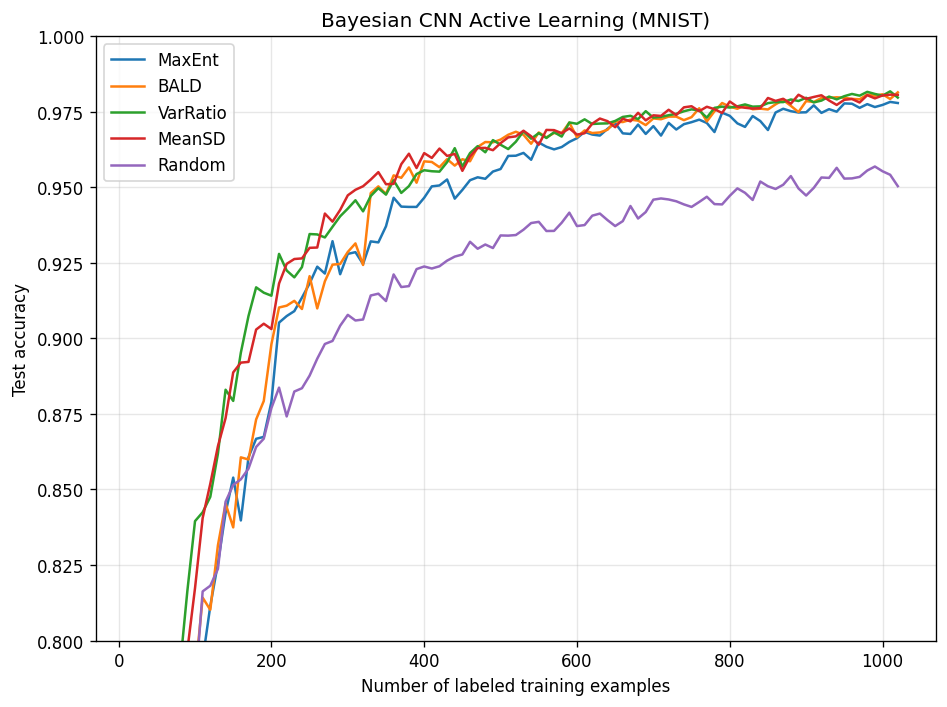

In [34]:
#@title Results for Replicating 5.1
acq_names = ["MaxEnt", "BALD", "VarRatio", "MeanSD","Random"]
output_dir = "outputs/replicate5-1/"

file_names = [output_dir + f'history_BCNN_{acq_name}_AVG_STATS.json' for acq_name in acq_names]
history_list = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        history = json.load(f)
        history_list.append(history)

plot_active_learning_curves(history_list, labels=acq_names, ylim=(0.8, 1.0), upper_field=None)

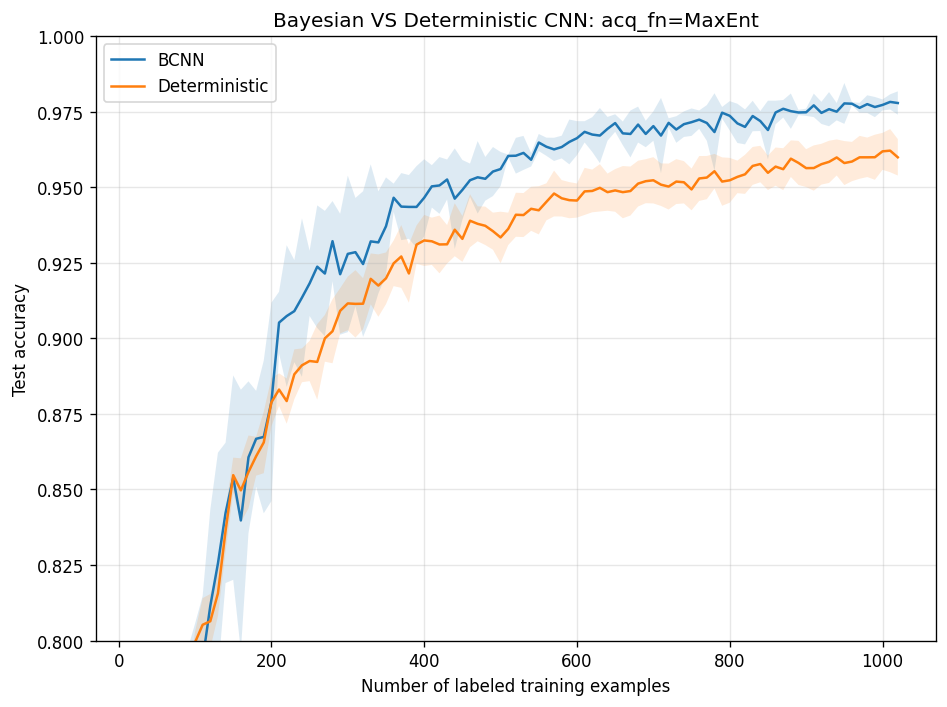

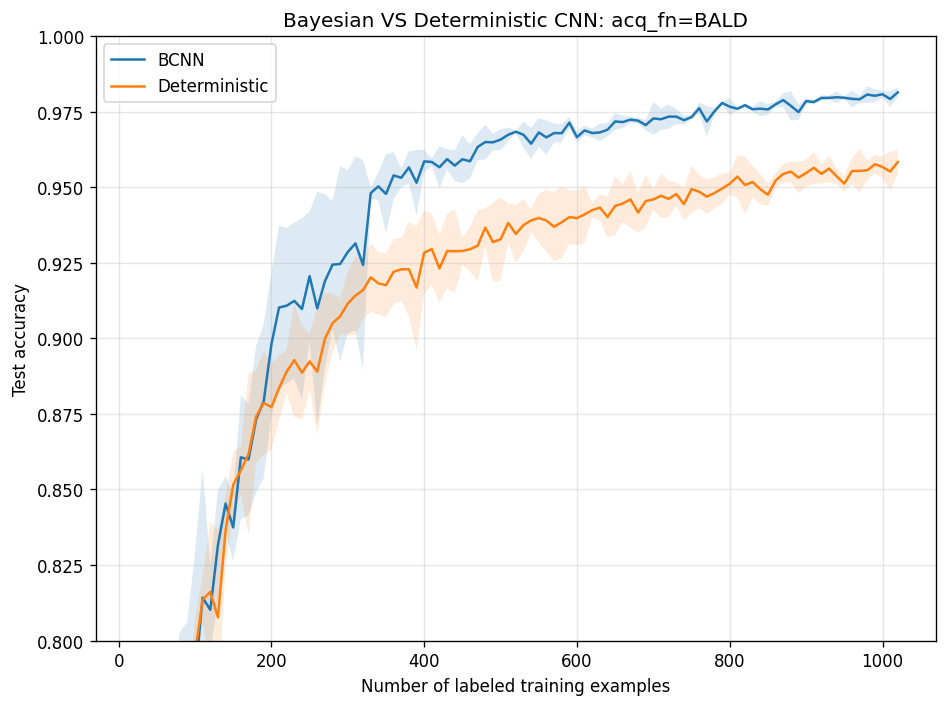

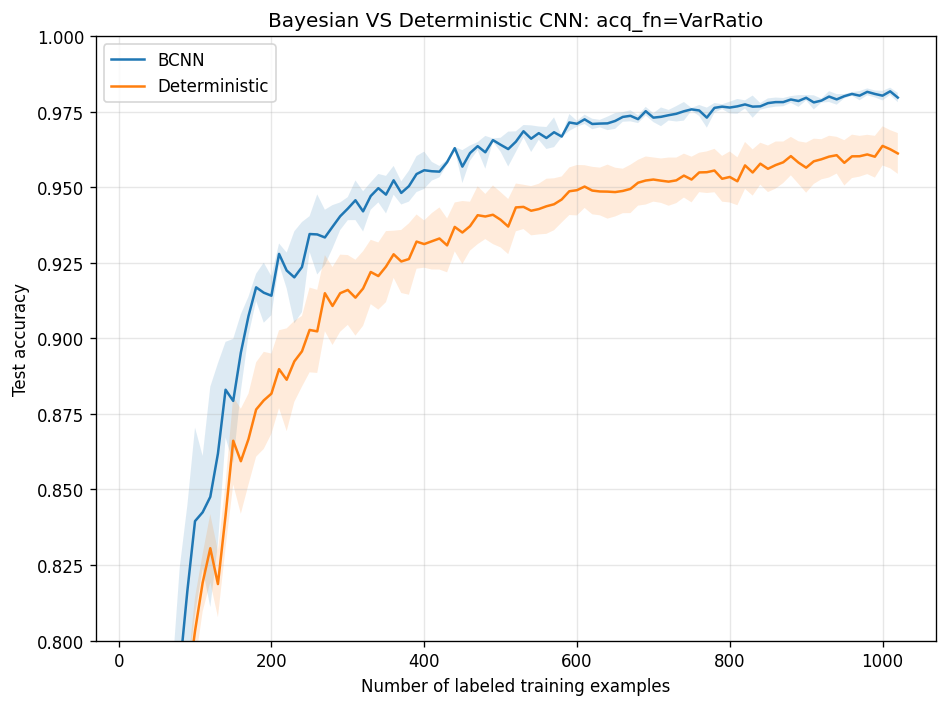

In [70]:
#@title Results for Replicating 5.2
acq_names = ["MaxEnt", "BALD", "VarRatio"]

file_name_pairs = []
for acq_name in acq_names:
    file_bcnn = f'outputs/replicate5-1/history_BCNN_{acq_name}_AVG_STATS.json'
    file_det = f'outputs/replicate5-2/history_deterministic_{acq_name}_AVG_STATS.json'
    file_name_pairs.append((file_bcnn, file_det))

for i, pair in enumerate(file_name_pairs):
    with open(pair[0], 'r') as f:
        history_bcnn = json.load(f)
    with open(pair[1], 'r') as f:
        history_det = json.load(f)

    labels = ["BCNN", "Deterministic"]
    plot_active_learning_curves([history_bcnn, history_det], labels=labels, ylim=(0.8, 1.0),
                                title=f"Bayesian VS Deterministic CNN: acq_fn={acq_names[i]}",
                                yfield="test_accs_mean")

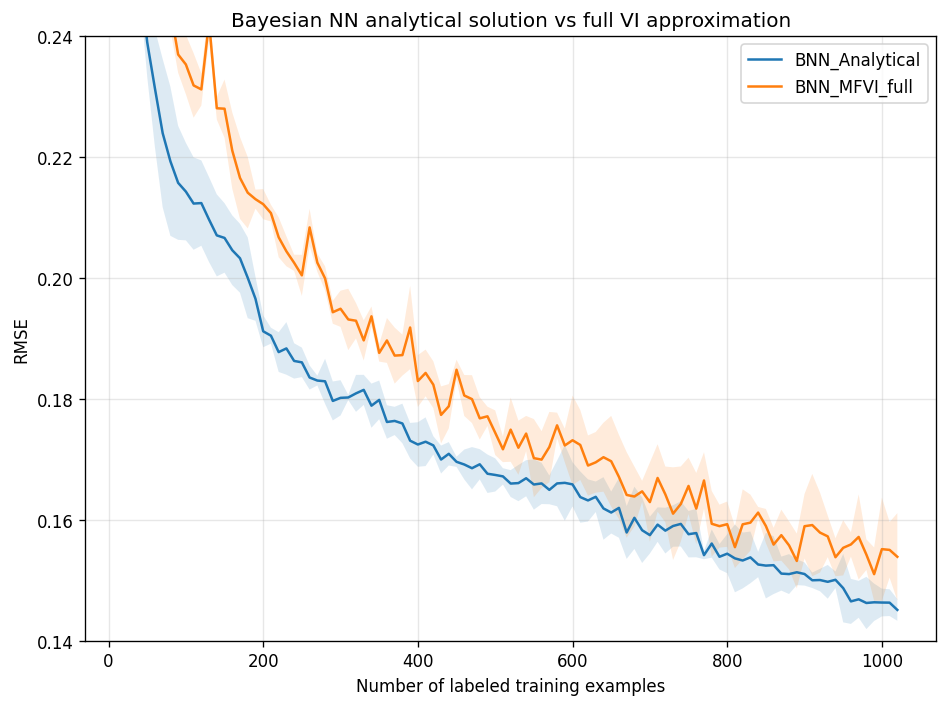

In [101]:
#@title Results for BNN Analytical vs MFVI
model_names = ["BNN_Analytical", "BNN_MFVI_full"]

file_names = ["outputs/bnn_analytical/history_BNN_Analytical_PredCovariance_AVG_STATS.json",
              "outputs/bnn_mfvi/history_BNN_MFVI_full_PredCovariance_AVG_STATS.json"]
history_list = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        history = json.load(f)
        history_list.append(history)

plot_active_learning_curves(history_list, labels=model_names,
                            title=f"Bayesian NN analytical solution vs full VI approximation",
                            ylabel="RMSE",
                            yfield="test_rmse_mean",
                            upper_field="test_rmse_std_upper",
                            lower_field="test_rmse_std_lower",
                            ylim=(0.14, 0.24))

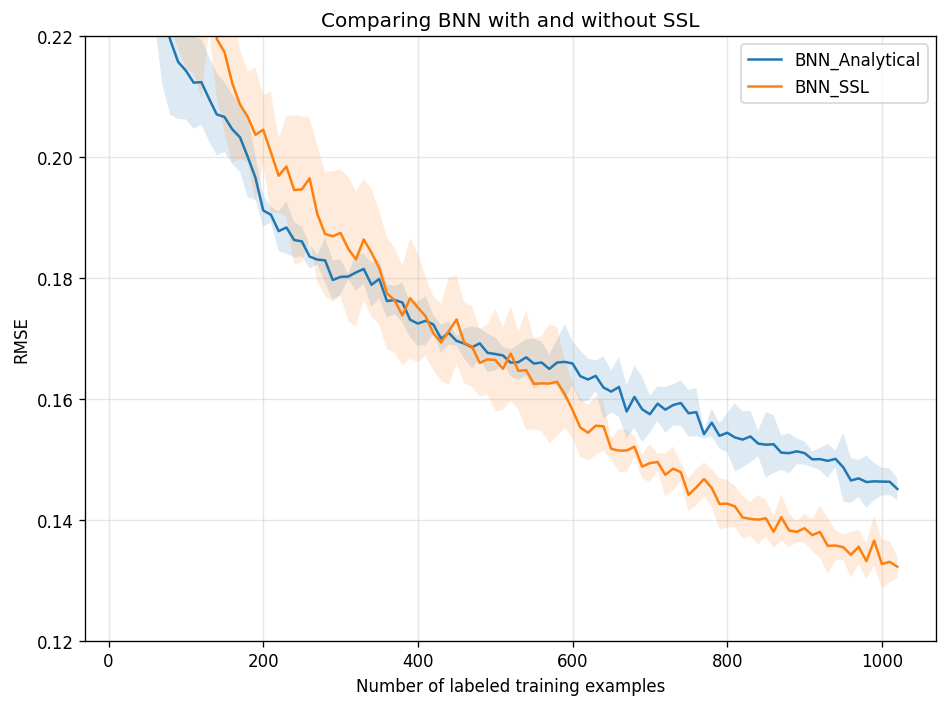

In [98]:
#@title Results for BNN SSL
model_names = ["BNN_Analytical", "BNN_SSL"]

file_names = ['outputs/bnn_analytical/history_BNN_Analytical_PredCovariance_AVG_STATS.json',
              'outputs/bnn_ssl/history_BNN_Analytical_PredCovariance_AVG_STATS.json']
history_list = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        history = json.load(f)
        history_list.append(history)

plot_active_learning_curves(history_list, labels=model_names,
                            title=f"Comparing BNN with and without SSL",
                            ylabel="RMSE",
                            yfield="test_rmse_mean",
                            upper_field="test_rmse_std_upper",
                            lower_field="test_rmse_std_lower",
                            ylim=(0.12, 0.22))

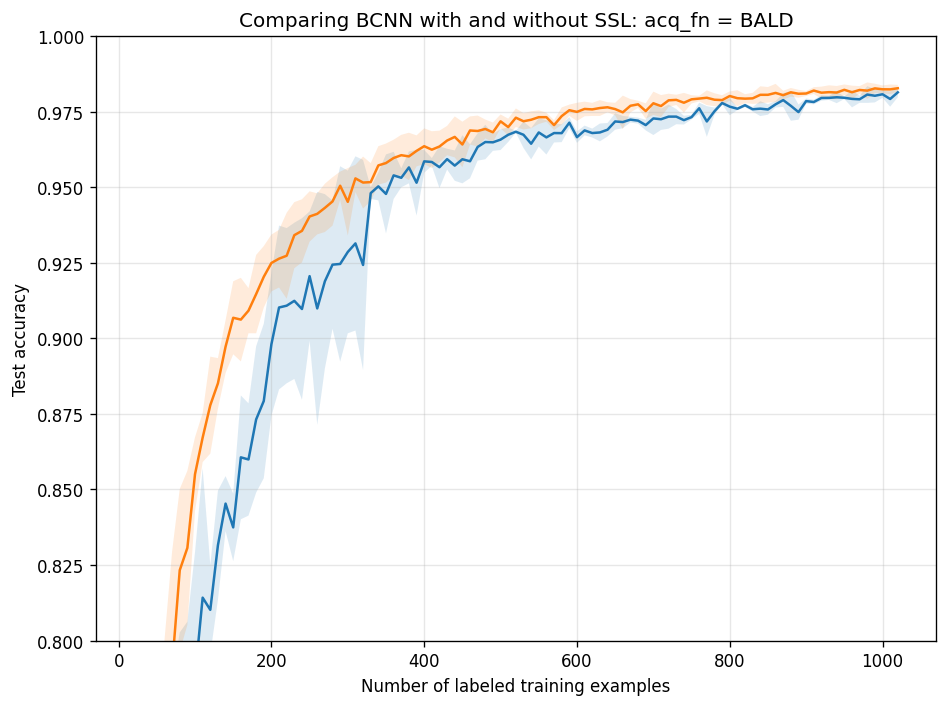

In [103]:
file_names = ["outputs/replicate5-1/history_BCNN_BALD_AVG_STATS.json", "outputs/cnn_ssl/history_CNN_SSL_BALD_AVG_STATS.json"]
history_list = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        history = json.load(f)
        history_list.append(history)

plot_active_learning_curves(history_list, ylim=(0.8, 1.0),
                            title="Comparing BCNN with and without SSL: acq_fn = BALD",
                            upper_field="test_accs_std_upper",
                            lower_field="test_accs_std_lower")

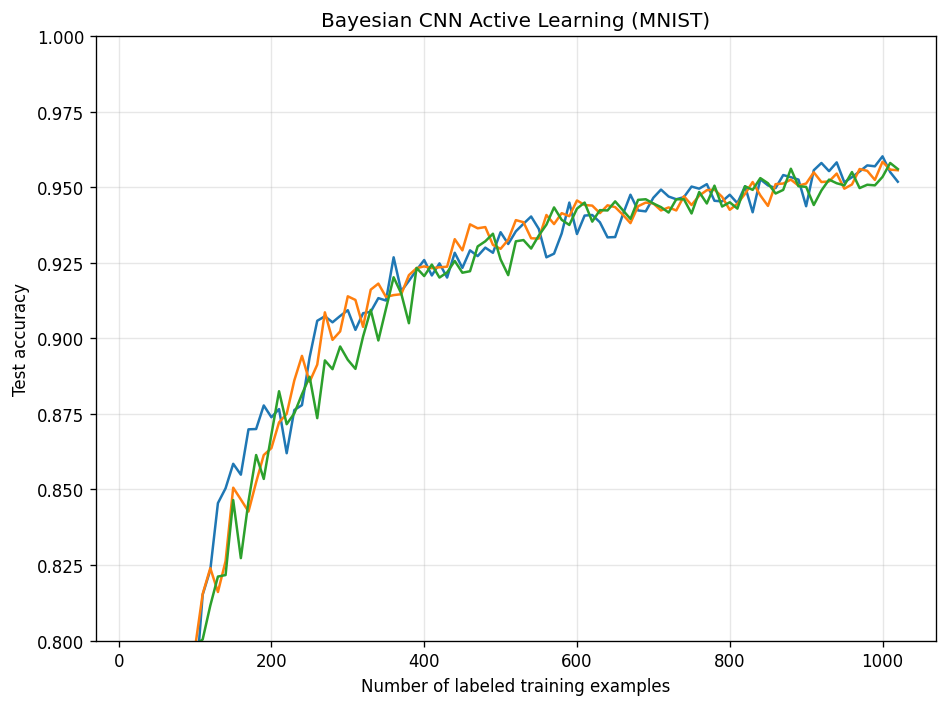

In [104]:
#@title Plot Any Graphs
file_names = [f"outputs/replicate5-2/history_deterministic_VarRatio_Run{i}.json" for i in range(3,6)]
history_list = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        history = json.load(f)
        history_list.append(history)

plot_active_learning_curves(history_list, labels=None, ylim=(0.8, 1.0), yfield="test_accs")

In [106]:
#@title Find Error Targets
acq_names = ["MaxEnt", "BALD", "VarRatio", "MeanSD","Random"]
file_names = [f"outputs/replicate5-1/history_BCNN_{acq_name}_AVG_STATS.json" for acq_name in acq_names]

for file_name in file_names:
    print(file_name)
    print("==" * 20)
    with open(file_name, 'r') as f:
        history = json.load(f)
        accs = history["test_accs_mean"]
        labs = history["labelled_set_sizes"]
        for acc, lab in zip(accs, labs):
            print(f"{lab} {acc}")


outputs/replicate5-1/history_BCNN_MaxEnt_AVG_STATS.json
20 0.47936666666666666
30 0.5590666666666667
40 0.5947999999999999
50 0.6377666666666667
60 0.6877
70 0.7312
80 0.7642000000000001
90 0.7678666666666666
100 0.7673333333333333
110 0.7936666666666667
120 0.8114666666666667
130 0.8255333333333333
140 0.8422666666666666
150 0.8539333333333333
160 0.8397666666666668
170 0.8606666666666666
180 0.8667666666666666
190 0.8674
200 0.8789666666666666
210 0.9052000000000001
220 0.9073666666666668
230 0.9089999999999999
240 0.9134666666666668
250 0.9181666666666667
260 0.9236999999999999
270 0.9214333333333333
280 0.9321333333333334
290 0.9211999999999999
300 0.9279333333333333
310 0.9285
320 0.9245666666666666
330 0.9320666666666667
340 0.9317333333333333
350 0.9370666666666666
360 0.9465
370 0.9435666666666668
380 0.9434666666666667
390 0.9434666666666667
400 0.9465
410 0.9502666666666667
420 0.9505666666666667
430 0.9525333333333332
440 0.9462
450 0.9491
460 0.9523
470 0.9532666666666666
4